# CAB Fare Prediction
                    

## Problem Statement

This case study is to predict the taxi fare for a taxi ride in New York City from a given pickup point to the agreed dropoff location. Decision tree and Random Forest regressor is used for the fare prediction.

## Data Definition

**unique_id**: Unique identifier or key for each record in the dataset - (string)    

**date_time_of_pickup**: time when the ride started - (timestamp)

**longitude_of_pickup**: Longitude of the taxi ride pickup point - (float) - (Numerical) 
 
**latitude_of_pickup**: Latitude of the taxi ride pickup point - (float) - (Numerical)
    
**longitude__of_dropoff**: Longitude of the taxi ride dropoff point  - (float) - (Numerical)
    
**latitude_of_dropoff**: Latitude of the taxi ride dropoff point - (float) - (Numerical)
    
**no_of_passenger**: count of the passengers during the ride - (integer) - (Numerical)
    
**amount**: (target variable)dollar amount of the cost of the taxi ride
   


#  Import Libraries

In [3]:
 
from warnings import filterwarnings
filterwarnings('ignore')
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from math import radians, cos, sin, sqrt, asin
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor


# Read Data

In [6]:
df_taxi = pd.read_csv('TaxiFare.csv')

df_taxi.head()

,unique_id,amount,date_time_of_pickup,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger
0,26:21.0,4.500000,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,52:16.0,16.900000,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,35:00.0,5.700000,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,30:42.0,7.700000,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,51:00.0,5.300000,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [7]:
df_taxi = df_taxi.drop('unique_id', axis = 1)


#  Prepare and Analyze the Data

In [ ]:

df_taxi.shape

(50000, 7)


### Data Type

In [ ]:

df_taxi.dtypes

In [9]:

df_taxi.date_time_of_pickup = pd.to_datetime(df_taxi.date_time_of_pickup, errors='coerce')

In [10]:
# recheck the data type of each column
df_taxi.dtypes

amount                              float64
date_time_of_pickup     datetime64[ns, UTC]
longitude_of_pickup                 float64
latitude_of_pickup                  float64
longitude_of_dropoff                float64
latitude_of_dropoff                 float64
no_of_passenger                       int64
dtype: object


### Feature Engineering



In [11]:
df_taxi.date_time_of_pickup.dt.hour

0        17
1        16
2         0
3         4
4         7
5         9
6        20
7        17
8        13
9         1
10        7
11       11
12        1
13       19
14       17
15       12
16        7
17       16
18       14
19       20
20       13
21       12
22       18
23       12
24       15
25       16
26       20
27       19
28        6
29        0
30       16
31       21
32       16
33       14
34       23
35        3
36        8
37       10
38       11
39       20
40       15
41       10
42        8
43       21
44       18
45       21
46       20
47        7
48        0
49       12
50        9
51       20
52        7
53        3
54        1
55       18
56       18
57       21
58       23
59       12
60       10
61       23
62       14
63        9
64       10
65       17
66        9
67       18
68       10
69       23
70        2
71       10
72        8
73       15
74       16
75        1
76       14
77        4
78       22
79       22
80       16
81       15
82        8
83  

In [13]:
type(df_taxi.date_time_of_pickup)

pandas.core.series.Series

In [15]:
type(df_taxi[['date_time_of_pickup']])

pandas.core.frame.DataFrame

In [16]:
# extract various date time components as seperate variables
df_taxi = df_taxi.assign(hour = df_taxi.date_time_of_pickup.dt.hour, 
                         day = df_taxi.date_time_of_pickup.dt.day,
                        month = df_taxi.date_time_of_pickup.dt.month, 
                        year = df_taxi.date_time_of_pickup.dt.year, 
                        dayofweek = df_taxi.date_time_of_pickup.dt.dayofweek)

In [16]:
a,b,c,d = map(radians,[180,100,200,300])
a,b,c,d

(3.141592653589793, 1.7453292519943295, 3.490658503988659, 5.235987755982989)

In [17]:
df_taxi.shape

(50000, 12)

In [18]:

def distance_transform(longitude1, latitude1, longitude2, latitude2):
    travel_dist = []
    
    for pos in range(len(longitude1)): #Traverse through each row
        long1,lati1,long2,lati2 = map(radians,[longitude1[pos],latitude1[pos],longitude2[pos],latitude2[pos]])
        dist_long = long2 - long1
        dist_lati = lati2 - lati1
        a = sin(dist_lati/2)**2 + cos(lati1) * cos(lati2) * sin(dist_long/2)**2
        c = 2 * asin(sqrt(a))*6371
        travel_dist.append(c)
       
    return travel_dist #Returns a list of distances

In [19]:
#Add a new variable travel distance

df_taxi['travel_dist_km'] = distance_transform(df_taxi['longitude_of_pickup'].to_numpy(),
                                                df_taxi['latitude_of_pickup'].to_numpy(),
                                                df_taxi['longitude_of_dropoff'].to_numpy(),
                                                df_taxi['latitude_of_dropoff'].to_numpy()
                                              )

In [20]:
#Check the newly added vaiarbles
df_taxi.head(5)

,amount,date_time_of_pickup,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger,hour,day,month,year,dayofweek,travel_dist_km
0,4.500000,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,17,15,6,2009,0,1.030764
1,16.900000,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,16,5,1,2010,1,8.450134
2,5.700000,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0,18,8,2011,3,1.389525
3,7.700000,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,4,21,4,2012,5,2.799270
4,5.300000,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,7,9,3,2010,1,1.999157


In [21]:

df_taxi = df_taxi.drop('date_time_of_pickup',axis=1)

In [22]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   amount                50000 non-null  float64
 1   longitude_of_pickup   50000 non-null  float64
 2   latitude_of_pickup    50000 non-null  float64
 3   longitude_of_dropoff  50000 non-null  float64
 4   latitude_of_dropoff   50000 non-null  float64
 5   no_of_passenger       50000 non-null  int64  
 6   hour                  50000 non-null  int64  
 7   day                   50000 non-null  int64  
 8   month                 50000 non-null  int64  
 9   year                  50000 non-null  int64  
 10  dayofweek             50000 non-null  int64  
 11  travel_dist_km        50000 non-null  float64
dtypes: float64(6), int64(6)
memory usage: 4.6 MB



### Discover Outliers

In [23]:

df_taxi = df_taxi.loc[(df_taxi.amount >= 2.5)] 

In [24]:
print("Remaining observastions in the dataset:", df_taxi.shape)

Remaining observastions in the dataset: (49990, 12)


In [25]:
foo = df_taxi.loc[(df_taxi.travel_dist_km >= 1) & (df_taxi.travel_dist_km <= 130)]
print("Remaining observastions in the dataset:", foo.shape)

Remaining observastions in the dataset: (40930, 12)


In [26]:
#We will only keep the observation where travel distance is less than or equal to 130
df_taxi = df_taxi.loc[(df_taxi.travel_dist_km >= 1) | (df_taxi.travel_dist_km <= 130)]
print("Remaining observastions in the dataset:", df_taxi.shape)

Remaining observastions in the dataset: (49990, 12)


3. Remove the observations with unreal longitude and latitude values , that is , 90< latitude <-90, 180 < longitude < -180.

In [27]:
incorrect_coordinates = df_taxi.loc[(df_taxi.latitude_of_pickup > 90) |(df_taxi.latitude_of_pickup < -90) |
                                   (df_taxi.latitude_of_dropoff > 90) |(df_taxi.latitude_of_dropoff < -90) |
                                   (df_taxi.longitude_of_pickup > 180) |(df_taxi.longitude_of_pickup < -180) |
                                   (df_taxi.longitude_of_dropoff > 90) |(df_taxi.longitude_of_dropoff < -90)
                                    ].index

In [28]:
df_taxi.drop(incorrect_coordinates, inplace = True, errors = 'ignore')

In [29]:
print("Remaining observastions in the dataset:", df_taxi.shape)

Remaining observastions in the dataset: (49989, 12)



### Missing Values

If the missing values are not handled properly we may end up drawing an inaccurate inference about the data.

In [30]:

Total = df_taxi.isnull().sum().sort_values(ascending = False)          


Percent = (df_taxi.isnull().sum()*100/df_taxi.isnull().count()).sort_values(ascending = False)   


missing_data = pd.concat([Total, Percent], axis = 1, keys = ['Total', 'Percentage of Missing Values'])    

# add the column containing data type of each variable
missing_data['Type'] = df_taxi[missing_data.index].dtypes
missing_data

,Total,Percentage of Missing Values,Type
amount,0,0.000000,float64
longitude_of_pickup,0,0.000000,float64
latitude_of_pickup,0,0.000000,float64
longitude_of_dropoff,0,0.000000,float64
latitude_of_dropoff,0,0.000000,float64
no_of_passenger,0,0.000000,int64
hour,0,0.000000,int64
day,0,0.000000,int64
month,0,0.000000,int64
year,0,0.000000,int64


** Visualize missing values using heatmap**

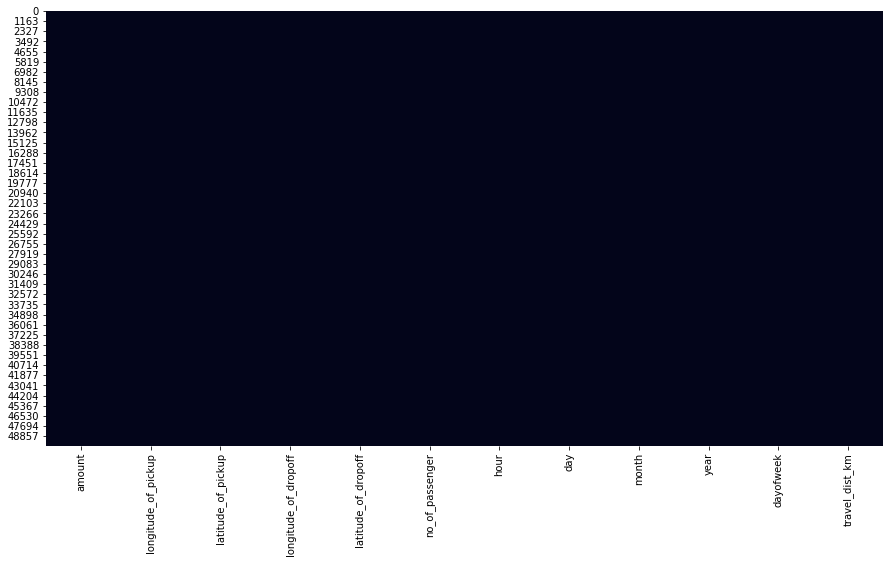

In [ ]:

sns.heatmap(df_taxi.isnull(), cbar=False)

# display the plot
plt.show()


###  Study correlation

In [31]:

corr = df_taxi.corr()

# print the correlation matrix
corr

,amount,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger,hour,day,month,year,dayofweek,travel_dist_km
amount,1.000000,0.005905,-0.006563,0.004452,-0.005600,0.016506,-0.022009,-0.001417,0.026742,0.121081,0.000542,0.016451
longitude_of_pickup,0.005905,1.000000,-0.984132,0.956613,-0.947401,-0.005614,0.004913,0.006008,0.000402,-0.001264,-0.003224,0.143712
latitude_of_pickup,-0.006563,-0.984132,1.000000,-0.943741,0.961374,0.003982,-0.004313,-0.008884,0.000498,-0.000925,0.001911,-0.130943
longitude_of_dropoff,0.004452,0.956613,-0.943741,1.000000,-0.982102,-0.004874,0.005506,0.005221,0.001322,-0.000327,-0.002441,0.143172
latitude_of_dropoff,-0.005600,-0.947401,0.961374,-0.982102,1.000000,0.002898,-0.004530,-0.008012,-0.000341,-0.001817,0.001626,-0.124844
no_of_passenger,0.016506,-0.005614,0.003982,-0.004874,0.002898,1.000000,0.011400,0.006787,0.009099,0.006385,0.038581,-0.005371
hour,-0.022009,0.004913,-0.004313,0.005506,-0.004530,0.011400,1.000000,-0.008192,-0.001916,0.004167,-0.091267,0.000644
day,-0.001417,0.006008,-0.008884,0.005221,-0.008012,0.006787,-0.008192,1.000000,-0.017266,-0.011155,0.008422,0.010610
month,0.026742,0.000402,0.000498,0.001322,-0.000341,0.009099,-0.001916,-0.017266,1.000000,-0.115726,-0.010004,-0.009217
year,0.121081,-0.001264,-0.000925,-0.000327,-0.001817,0.006385,0.004167,-0.011155,-0.115726,1.000000,0.006808,0.022136


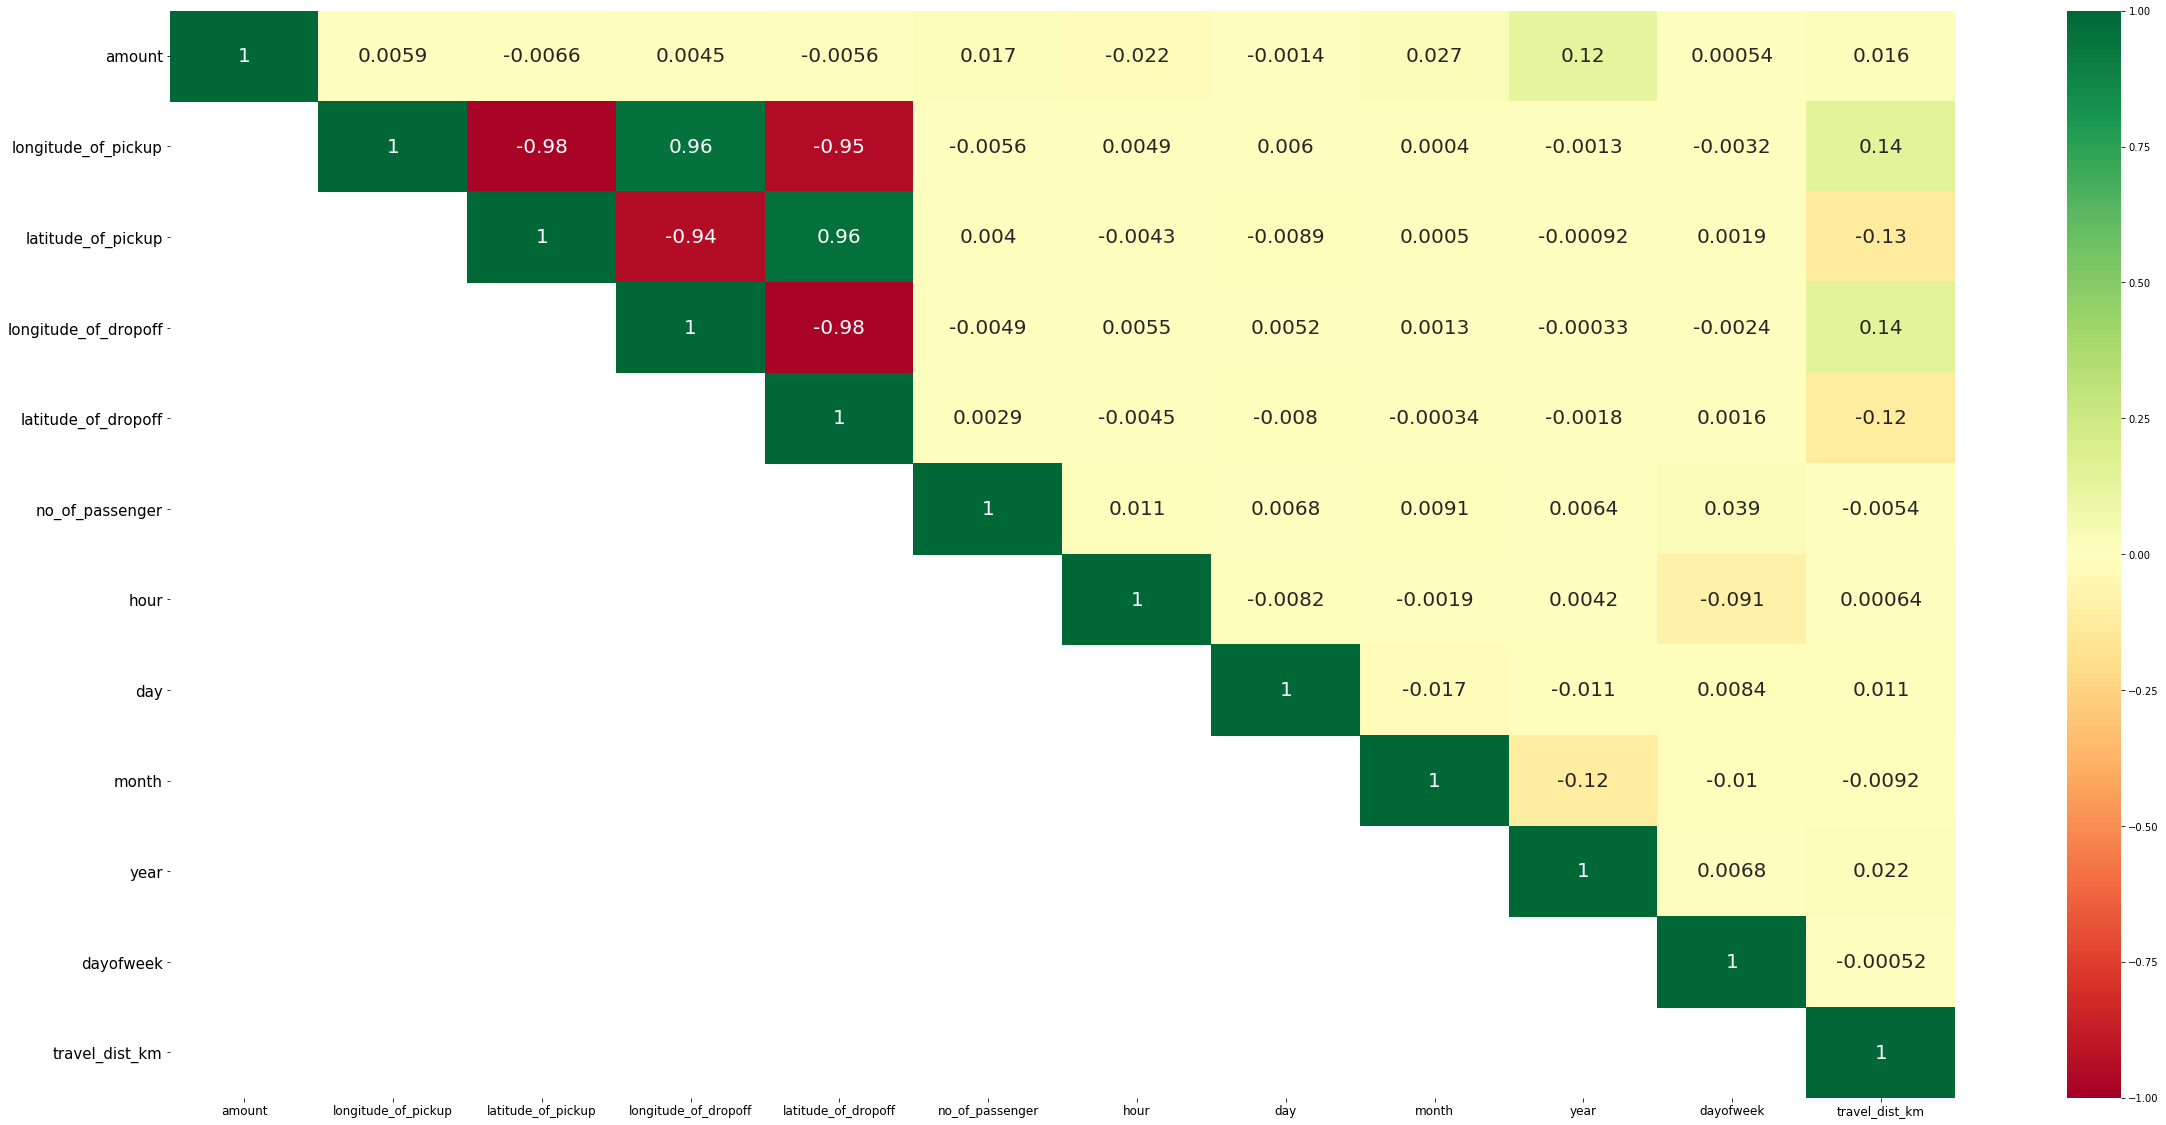

In [ ]:
 
plt.figure(figsize = (40,20))

mask = np.zeros_like(corr)
mask[np.tril_indices_from(mask, k = -1)] = True


sns.heatmap(corr, cmap = 'RdYlGn', vmax = 1.0, vmin = -1.0, annot = True, annot_kws = {"size": 20}, mask = mask)


plt.xticks(fontsize = 12)
plt.yticks(fontsize = 15)

# display the plot
plt.show()

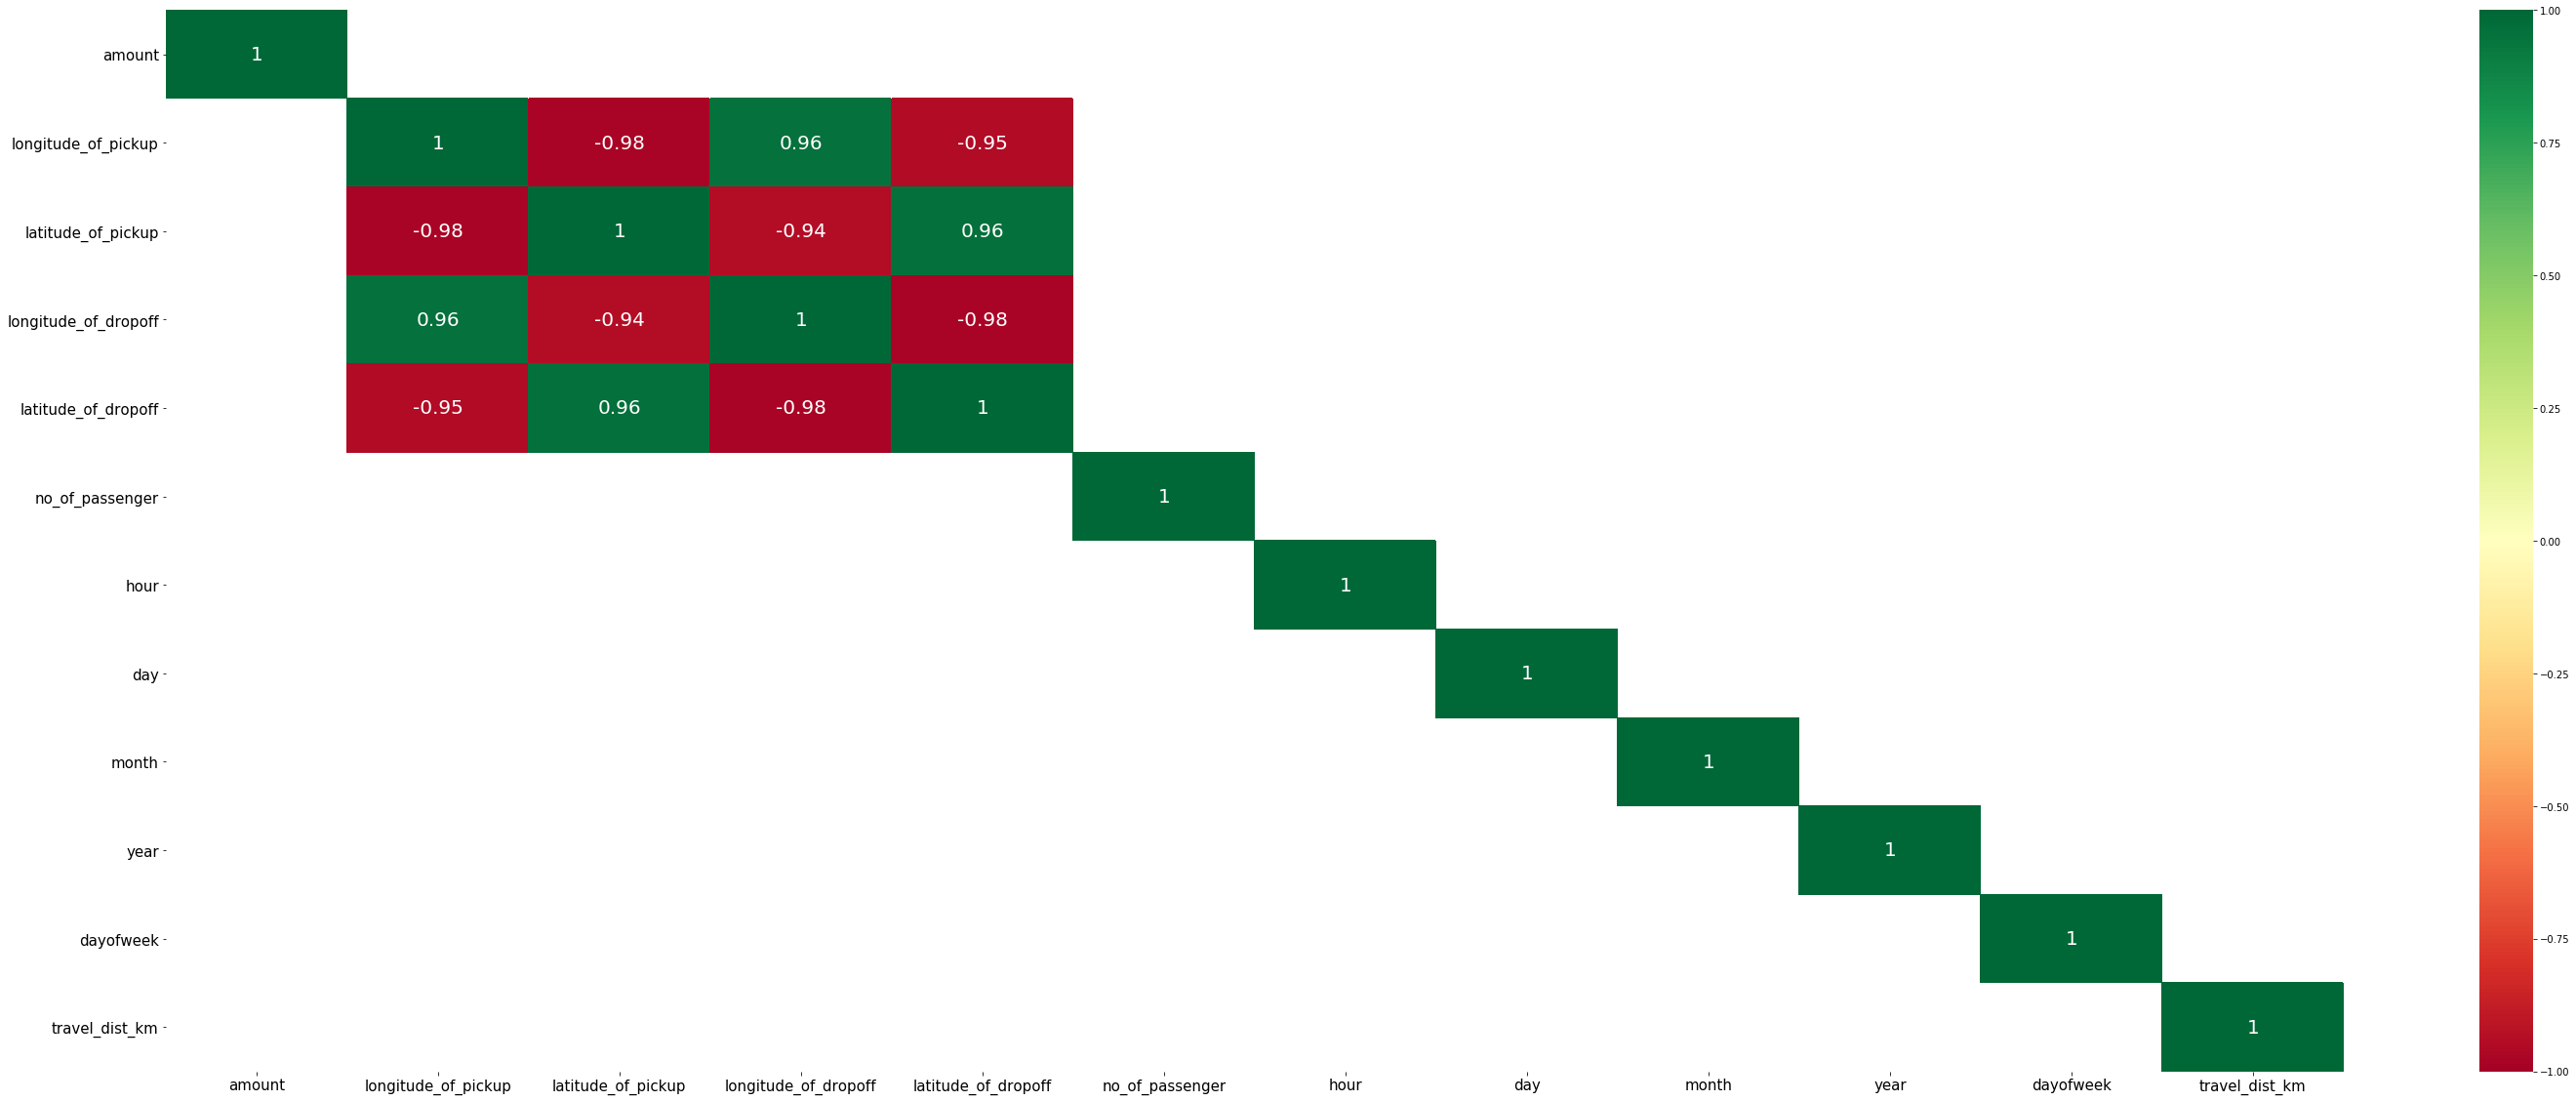

In [ ]:
# set figure size
plt.figure(figsize=(50, 20))


sns.heatmap(corr[(corr >= 0.7) | (corr <= -0.7)], cmap = 'RdYlGn', vmax = 1.0, vmin = -1.0, annot = True, 
            annot_kws={"size": 20})


plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

# display the plot
plt.show()


## Exploratory Data Analysis


###  Peak hours

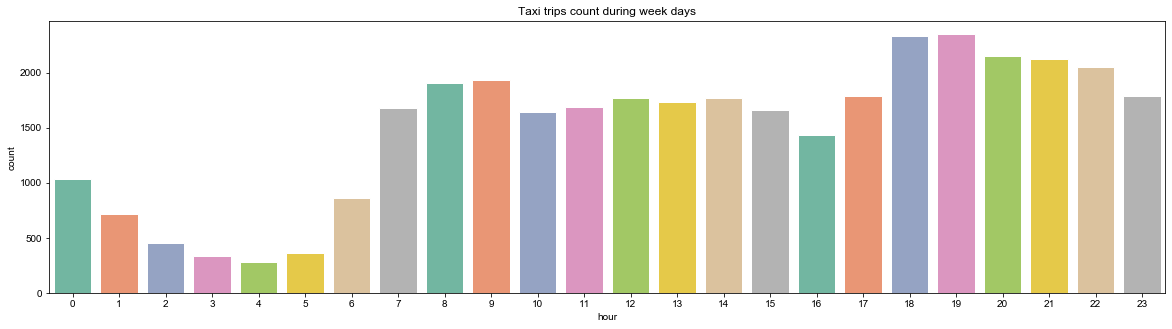

In [ ]:
# Set the figure size, grid type and color palette along with appropraite titel for the plot
plt.figure(figsize=(20,5))
plt.title('Taxi trips count during week days')
sns.set_style("white")
#plot the countplot for weekdays
sns.countplot(x='hour', data=df_taxi.loc[(df_taxi.dayofweek >= 0) & (df_taxi.dayofweek <=4)], palette='Set2')

** Plot a countplot to check the peak hours during weekends**

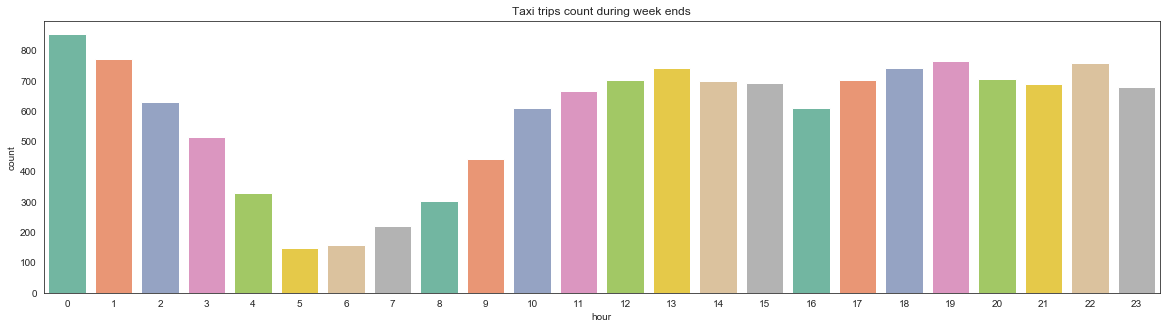

In [ ]:
# Set the figure size, grid type and color palette along with appropraite titel for the plot
plt.figure(figsize=(20,5))
plt.title('Taxi trips count during week ends')
sns.set_style("white")
#plot the countplot for weekends
sns.countplot(x='hour', data=df_taxi.loc[(df_taxi.dayofweek >= 5) & (df_taxi.dayofweek <=6)], palette='Set2')


### Mean fare for each hour during weekdays and weekends

In [32]:
week_days = df_taxi.loc[(df_taxi.dayofweek >= 0) & (df_taxi.dayofweek <= 4)]
week_ends = df_taxi.loc[(df_taxi.dayofweek >= 5) & (df_taxi.dayofweek <= 6)]
week_days_fare = week_days.groupby(['hour']).amount.mean().to_frame().reset_index()
week_ends_fare = week_ends.groupby(['hour']).amount.mean().to_frame().reset_index()

** Plot the mean fare**

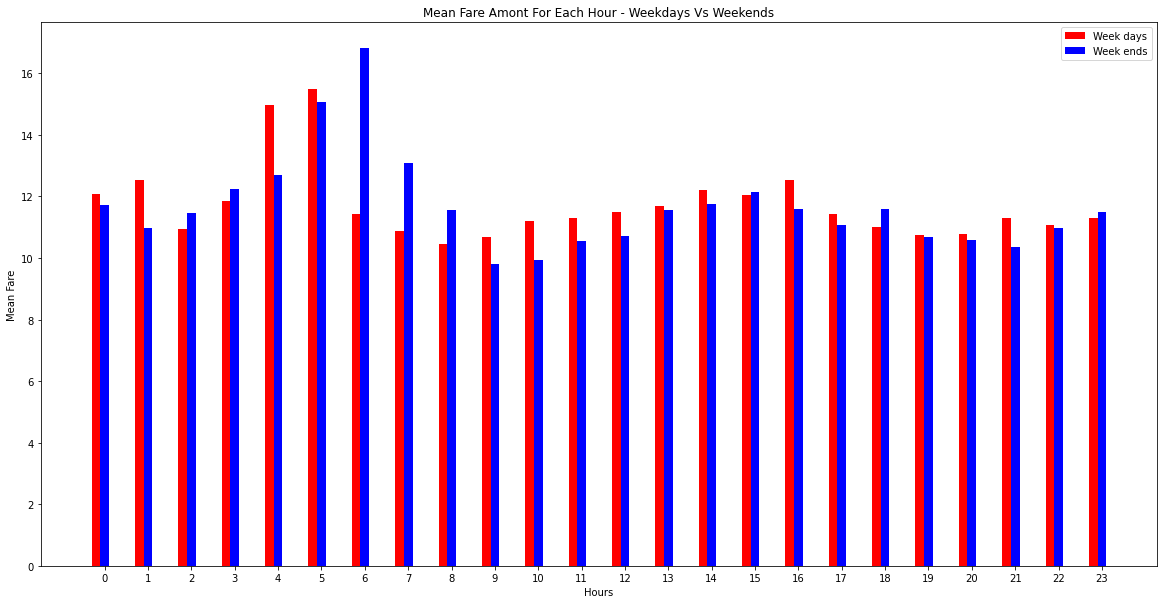

In [33]:

x = np.array(week_days_fare.hour)
# an array of week day fare 
y = np.array(week_days_fare.amount)
# an array of week end fare
z = np.array(week_ends_fare.amount)

plt.figure(figsize = (20,10))
plt.title('Mean Fare Amont For Each Hour - Weekdays Vs Weekends')
plt.xlabel('Hours')
plt.ylabel('Mean Fare')
ax=plt.subplot(1,1,1)
ax.bar(x-0.2, y, width=0.2, color='red', align='center', label = 'Week days')
ax.bar(x, z, width=0.2, color='blue', align='center', label = 'Week ends')
plt.xticks(range(0,24))
plt.legend()
plt.show()



###  Distribution of key numerical vairables

** Distribution of fare 'amount'**

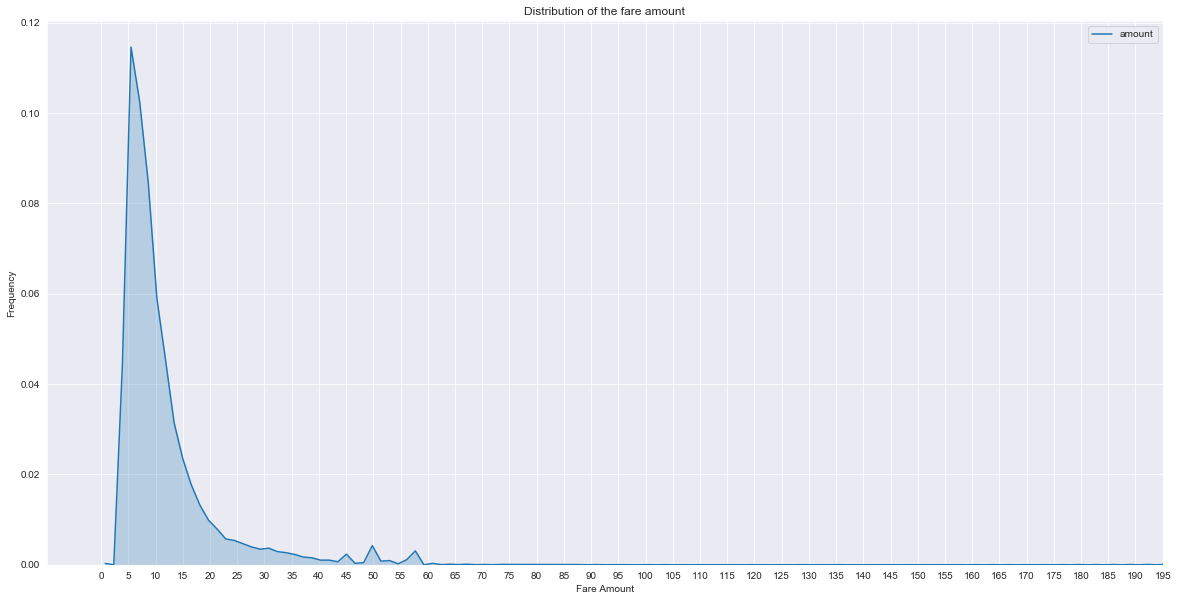

In [ ]:
plt.figure(figsize=(20,10))
sns.set_style("darkgrid")
plt.title("Distribution of the fare amount")
plt.xlabel("Fare Amount")
plt.ylabel("Frequency")
plt.xlim(-10,20)
plt.xticks(range(0,200,5))

snsplot = sns.kdeplot(df_taxi.amount, shade=True)


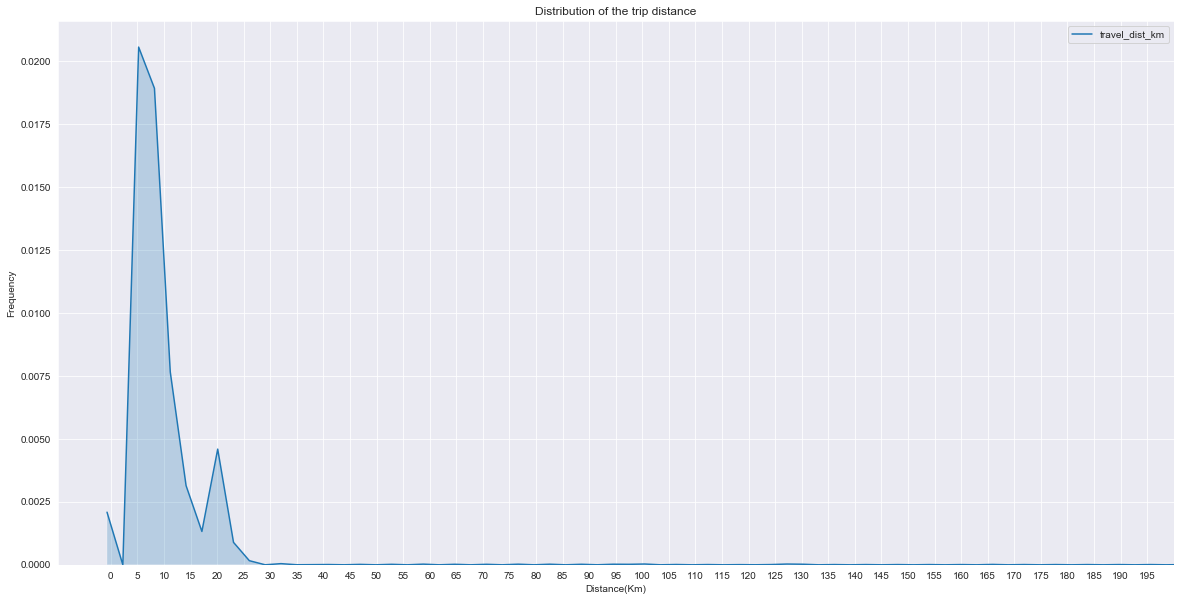

In [ ]:
plt.figure(figsize = (20,10))
sns.style = ('darkgrid')
plt.title("Distribution of the trip distance")
plt.xlabel("Distance(Km)")
plt.ylabel("Frequency")
plt.xlim(-10, 200)
plt.xticks(range(0,200,5))

sns.plot = sns.kdeplot(df_taxi[df_taxi.travel_dist_km<600].travel_dist_km, shade=True)

<a id='Random_Forest'></a>
# 5.  Random Forest

It is an example of the `Bagging` technique. It constructs multiple decision trees on randomly selected data samples. We can use the bootstrap sampling method to select the random samples of the same size from the dataset to construct multiple trees.

In this section we build a model using random forest regressor.

In [34]:
# select only the target variable 'amount' and store it in dataframe 'y'
y = pd.DataFrame(df_taxi['amount'])

In [35]:

X = df_taxi.drop('amount',axis = 1)

In [37]:
X.shape, y.shape

((49989, 11), (49989, 1))

In [36]:
X.head()

,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger,hour,day,month,year,dayofweek,travel_dist_km
0,-73.844311,40.721319,-73.841610,40.712278,1,17,15,6,2009,0,1.030764
1,-74.016048,40.711303,-73.979268,40.782004,1,16,5,1,2010,1,8.450134
2,-73.982738,40.761270,-73.991242,40.750562,2,0,18,8,2011,3,1.389525
3,-73.987130,40.733143,-73.991567,40.758092,1,4,21,4,2012,5,2.799270
4,-73.968095,40.768008,-73.956655,40.783762,1,7,9,3,2010,1,1.999157


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

print("The shape of X_train is:",X_train.shape)

print("The shape of X_test is:",X_test.shape)

print("The shape of y_train is:",y_train.shape)

print("The shape of y_test is:",y_test.shape)

The shape of X_train is: (34992, 11)
The shape of X_test is: (14997, 11)
The shape of y_train is: (34992, 1)
The shape of y_test is: (14997, 1)


In [39]:
rf_reg = RandomForestRegressor(n_estimators=100, random_state=10) #100 random decision trees will be build
rf_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=10)

In [40]:

y_pred = rf_reg.predict(X_test)

In [41]:
# Calculate MAE
rf_reg_MAE = metrics.mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error (MAE):', rf_reg_MAE)

# Calculate MSE
rf_reg_MSE = metrics.mean_squared_error(y_test, y_pred)
print('Mean Squared Error (MSE):', rf_reg_MSE)

# Calculate RMSE
rf_reg_RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', rf_reg_RMSE)

Mean Absolute Error (MAE): 2.068533828114829
Mean Squared Error (MSE): 19.630229608323198
Root Mean Squared Error (RMSE): 4.430601495093324


## Tabulate the results**

In [42]:

cols = ['Model', 'MAE', 'MSE', 'RMSE']


result_tabulation = pd.DataFrame(columns = cols)

# compile the required information
rf_reg_metrics = pd.Series({'Model': "Random Forest ",
                     'MAE':rf_reg_MAE,
                     'MSE': rf_reg_MSE,
                     'RMSE': rf_reg_RMSE     
                   })


result_tabulation = result_tabulation.append(rf_reg_metrics, ignore_index = True)

# print the result table
result_tabulation

,Model,MAE,MSE,RMSE
0,Random Forest,2.068534,19.630230,4.430601



##  Random Forest with GridSearchCV

In [43]:

tuned_paramaters = [{'n_estimators': [ 85, 100],
                     'min_samples_split': [15,20],
                     'max_depth': [8, 10]
                     #'min_samples_leaf': [5,10],
                     #'max_leaf_nodes': [10, 15]
                    }]

In [44]:

rf_reg_CV= RandomForestRegressor(random_state = 10)

grid = GridSearchCV(estimator = rf_reg_CV, 
                         param_grid = tuned_paramaters, 
                         cv = 10)


dt_grid = grid.fit(X_train, y_train)

# get the best parameters
print('Best parameters for random forest regressor: ', dt_grid.best_params_, '\n')

Best parameters for random forest regressor:  {'max_depth': 10, 'min_samples_split': 20, 'n_estimators': 85} 



**2. Build the model using the hyperparameters obtained in step 1**

In [ ]:

dt_grid_model = RandomForestRegressor(n_estimators = dt_grid.best_params_.get('n_estimators'),
                                       max_depth = dt_grid.best_params_.get('max_depth'),
                                       min_samples_split = dt_grid.best_params_.get('min_samples_split'),
                                       random_state = 10)

dt_grid_model = dt_grid_model.fit(X_train, y_train)

In [ ]:
y_pred = dt_grid_model.predict(X_test)

In [ ]:
# calculate MAE
rf_reg_CV_MAE = metrics.mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error (MAE):', rf_reg_CV_MAE)
                                         
# calculate MSE
rf_reg_CV_MSE = metrics.mean_squared_error(y_test, y_pred)
print('Mean Squared Error (MSE):', rf_reg_CV_MSE)
                                         
# calculate RMSE
rf_reg_CV_RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', rf_reg_CV_RMSE)

Mean Absolute Error (MAE): 2.108015582329935
Mean Squared Error (MSE): 19.952915628853532
Root Mean Squared Error (RMSE): 4.466868660354089


### Tabulate the results**

In [ ]:

rf_reg_metrics = pd.Series({'Model': "Random Forest ",
                     'MAE':rf_reg_CV_MAE,
                     'MSE': rf_reg_CV_MSE,
                     'RMSE': rf_reg_CV_RMSE     
                   })

result_tabulation = result_tabulation.append(rf_reg_metrics, ignore_index = True)

# print the result table
result_tabulation

,Model,MAE,MSE,RMSE
0,Random Forest,2.068623,19.590861,4.426156
1,Random Forest,2.108016,19.952916,4.466869



# Conclusion

#### The regression algorithms named in the above table have been implemented on the given dataset. The performance of the models were evaluated using MAE, MSE,RMSE. 
#### The above result shows that the RMSE value for both the model is much less than the standard deviation of the 'amount' (target) variable. Both the models have performed well. We can further fine tune the model for various hyperparameter values.
                  